In [5]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install catboost

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install ipywidgets

Note: you may need to restart the kernel to use updated packages.


In [33]:
import numpy as np
import pandas as pd
import lightgbm
from lightgbm import LGBMRegressor
import catboost
from catboost import CatBoostRegressor
import sklearn
from sklearn.model_selection import KFold
import IPython
from IPython.display import clear_output
import copy
import matplotlib.pyplot as plt

In [4]:
# import datasets
train = pd.read_csv('../dataset/train.csv')
test = pd.read_csv('../dataset/test.csv')
building = pd.read_csv('../dataset/building_info.csv')
submission = pd.read_csv('../dataset/sample_submission.csv')

In [7]:
display(train)
display(test)

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh)
0,1_20220601 00,1,20220601 00,18.6,NaN,0.9,42.0,NaN,NaN,1085.28
1,1_20220601 01,1,20220601 01,18.0,NaN,1.1,45.0,NaN,NaN,1047.36
2,1_20220601 02,1,20220601 02,17.7,NaN,1.5,45.0,NaN,NaN,974.88
3,1_20220601 03,1,20220601 03,16.7,NaN,1.4,48.0,NaN,NaN,953.76
4,1_20220601 04,1,20220601 04,18.4,NaN,2.8,43.0,NaN,NaN,986.40
...,...,...,...,...,...,...,...,...,...,...
203995,100_20220824 19,100,20220824 19,23.1,NaN,0.9,86.0,0.5,NaN,881.04
203996,100_20220824 20,100,20220824 20,22.4,NaN,1.3,86.0,0.0,NaN,798.96
203997,100_20220824 21,100,20220824 21,21.3,NaN,1.0,92.0,NaN,NaN,825.12
203998,100_20220824 22,100,20220824 22,21.0,NaN,0.3,94.0,NaN,NaN,640.08


,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%)
0,1_20220825 00,1,20220825 00,23.5,0.0,2.2,72
1,1_20220825 01,1,20220825 01,23.0,0.0,0.9,72
2,1_20220825 02,1,20220825 02,22.7,0.0,1.5,75
3,1_20220825 03,1,20220825 03,22.1,0.0,1.3,78
4,1_20220825 04,1,20220825 04,21.8,0.0,1.0,77
...,...,...,...,...,...,...,...
16795,100_20220831 19,100,20220831 19,22.5,0.0,0.9,84
16796,100_20220831 20,100,20220831 20,20.7,0.0,0.4,95
16797,100_20220831 21,100,20220831 21,20.2,0.0,0.4,98
16798,100_20220831 22,100,20220831 22,20.1,0.0,1.1,97


In [75]:
train_df = train.copy()

train_df = train_df.drop(columns =  ['num_date_time', '일조(hr)', '일사(MJ/m2)'])
train_df = train_df.rename(columns = {'기온(C)':'기온', '강수량(mm)':'강수량', '풍속(m/s)':'풍속', '습도(%)':'습도', '전력소비량(kWh)':'전력소비량'})
train_df['일시'] = pd.to_datetime(train_df['일시'])
train_df['시간'] = train_df['일시'].dt.hour
train_df['요일'] = train_df['일시'].dt.weekday
train_df['주말'] = train_df['요일'].isin([5,6]).astype(int)
train_df = train_df.fillna(0)
train_df = train_df.drop(columns = '일시')

In [76]:
T = 9/5*train_df['기온']
train_df['불쾌지수'] = T - 0.55*(1-train_df['습도']/100)*(T-26)+32
train_df['불쾌지수'] = pd.cut(train_df['불쾌지수'], bins = [0, 68, 75, 80, 200], labels = [1, 2, 3, 4])

(array([22498.,     0.,     0., 59862.,     0.,     0., 80715.,     0.,
            0., 40925.]),
 array([1. , 1.3, 1.6, 1.9, 2.2, 2.5, 2.8, 3.1, 3.4, 3.7, 4. ]),
 <BarContainer object of 10 artists>)

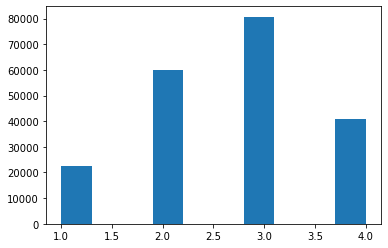

In [77]:
plt.hist(train_df['불쾌지수'])

In [78]:
train_df

,건물번호,기온,강수량,풍속,습도,전력소비량,시간,요일,주말,불쾌지수
0,1,18.6,0.0,0.9,42.0,1085.28,0,2,0,1
1,1,18.0,0.0,1.1,45.0,1047.36,1,2,0,1
2,1,17.7,0.0,1.5,45.0,974.88,2,2,0,1
3,1,16.7,0.0,1.4,48.0,953.76,3,2,0,1
4,1,18.4,0.0,2.8,43.0,986.40,4,2,0,1
...,...,...,...,...,...,...,...,...,...,...
203995,100,23.1,0.0,0.9,86.0,881.04,19,2,0,2
203996,100,22.4,0.0,1.3,86.0,798.96,20,2,0,2
203997,100,21.3,0.0,1.0,92.0,825.12,21,2,0,2
203998,100,21.0,0.0,0.3,94.0,640.08,22,2,0,2


In [79]:
def CDH(x):
    y = []
    for i in range(len(x)):
        if i<11:
            y.append(np.sum(x[:(i+1)]-26))
        else:
            y.append(np.sum(x[(i-11):(i+1)]-26))
    return np.array(x)

In [80]:
cdhs = np.array([])

for num in range(1, 101):
    temp = train_df[train_df['건물번호'] == num]
    cdh = CDH(temp['기온'].values)
    cdhs = np.concatenate([cdhs, cdh])

train_df['CDH'] = cdhs

In [81]:
train_df

,건물번호,기온,강수량,풍속,습도,전력소비량,시간,요일,주말,불쾌지수,CDH
0,1,18.6,0.0,0.9,42.0,1085.28,0,2,0,1,18.6
1,1,18.0,0.0,1.1,45.0,1047.36,1,2,0,1,18.0
2,1,17.7,0.0,1.5,45.0,974.88,2,2,0,1,17.7
3,1,16.7,0.0,1.4,48.0,953.76,3,2,0,1,16.7
4,1,18.4,0.0,2.8,43.0,986.40,4,2,0,1,18.4
...,...,...,...,...,...,...,...,...,...,...,...
203995,100,23.1,0.0,0.9,86.0,881.04,19,2,0,2,23.1
203996,100,22.4,0.0,1.3,86.0,798.96,20,2,0,2,22.4
203997,100,21.3,0.0,1.0,92.0,825.12,21,2,0,2,21.3
203998,100,21.0,0.0,0.3,94.0,640.08,22,2,0,2,21.0


In [106]:
train_ = train_df.copy()
train_input = train_.drop(columns = '전력소비량')
train_target = train_df['전력소비량']

In [145]:
test_df = test.copy()

test_df = test_df.drop(columns =  ['num_date_time'])
test_df = test_df.rename(columns = {'기온(C)':'기온', '강수량(mm)':'강수량', '풍속(m/s)':'풍속', '습도(%)':'습도', '전력소비량(kWh)':'전력소비량'})
test_df['일시'] = pd.to_datetime(test_df['일시'])
test_df['시간'] = test_df['일시'].dt.hour
test_df['요일'] = test_df['일시'].dt.weekday
test_df['주말'] = test_df['요일'].isin([5,6]).astype(int)
test_df = test_df.fillna(0)
test_df = test_df.drop(columns = '일시')

T = 9/5*test_df['기온']
test_df['불쾌지수'] = T - 0.55*(1-test_df['습도']/100)*(T-26)+32
test_df['불쾌지수'] = pd.cut(test_df['불쾌지수'], bins = [0, 68, 75, 80, 200], labels = [1, 2, 3, 4])

cdhs = np.array([])
for num in range(1, 101):
    temp = test_df[test_df['건물번호'] == num]
    cdh = CDH(temp['기온'].values)
    cdhs = np.concatenate([cdhs, cdh])

test_df['CDH'] = cdhs

test_df = test_df[['건물번호', '기온', '강수량', '풍속', '습도', '시간', '요일', '주말', '불쾌지수', 'CDH']]
test_dfs  = []
for i in range(1,101):
    test_dfs.append(test_df[test_df['건물번호']==i])

test_df 


,건물번호,기온,강수량,풍속,습도,시간,요일,주말,불쾌지수,CDH
0,1,23.5,0.0,2.2,72,0,3,0,2,23.5
1,1,23.0,0.0,0.9,72,1,3,0,2,23.0
2,1,22.7,0.0,1.5,75,2,3,0,2,22.7
3,1,22.1,0.0,1.3,78,3,3,0,2,22.1
4,1,21.8,0.0,1.0,77,4,3,0,2,21.8
...,...,...,...,...,...,...,...,...,...,...
16795,100,22.5,0.0,0.9,84,19,2,0,2,22.5
16796,100,20.7,0.0,0.4,95,20,2,0,2,20.7
16797,100,20.2,0.0,0.4,98,21,2,0,2,20.2
16798,100,20.1,0.0,1.1,97,22,2,0,2,20.1


In [137]:
train_df.columns

Index(['건물번호', '기온', '강수량', '풍속', '습도', '전력소비량', '시간', '요일', '주말', '불쾌지수',
       'CDH'],
      dtype='object')

In [140]:
train_df = train_df[['전력소비량', '건물번호', '기온', '강수량', '풍속', '습도', '시간', '요일', '주말', '불쾌지수', 'CDH']]
train_dfs  = []
for i in range(1,101):
    train_dfs.append(train_df[train_df['건물번호']==i]) 

In [141]:
train_input = [] 
train_target = []

for i in range(len(train_dfs)):
    train_input.append(copy.deepcopy(train_dfs[i][train_dfs[i].columns[1:]])) 
    train_target.append(copy.deepcopy(train_dfs[i][train_dfs[i].columns[0]]))

In [128]:
train_dfs[98]

,건물번호,기온,강수량,풍속,습도,전력소비량,시간,요일,주말,불쾌지수,CDH
199920,99,23.1,0.0,1.4,17.0,642.96,0,2,0,1,23.1
199921,99,23.1,0.0,3.0,17.0,603.36,1,2,0,1,23.1
199922,99,23.1,0.0,1.6,17.0,581.22,2,2,0,1,23.1
199923,99,23.0,0.0,2.6,18.0,599.94,3,2,0,1,23.0
199924,99,21.2,0.0,1.2,23.0,595.62,4,2,0,1,21.2
...,...,...,...,...,...,...,...,...,...,...,...
201955,99,21.9,0.0,0.1,80.0,1299.24,19,2,0,2,21.9
201956,99,20.6,0.0,1.0,85.0,1276.92,20,2,0,2,20.6
201957,99,20.1,0.0,0.8,86.0,1062.00,21,2,0,1,20.1
201958,99,19.4,0.0,0.7,88.0,865.62,22,2,0,1,19.4


In [156]:
random_seed = 42
features = [[], '강수량', '풍속']
K = [i for i in [5, 8, 10]]

cat_mae_params = {
    'objective': 'MAE',
    'n_estimators': 10000,
    'early_stopping_rounds': 4, 
} # catboost hyper parameter

lgbm_mae_params = {
    'objective': 'MAE',
    'boosting_type': 'goss',
    'n_estimators': 10000,
    'early_stopping_round': 15, 
    'num_leaves':39,
} # lightgbm hyper parameter

for feature in features: # 특정 feature dc를 drop 시킴
    for k in K: # kfold 의 nspilt 의 값 k
        folds = []
        for i in range(len(train_dfs)):
            cross = KFold(n_splits = k, shuffle = True, random_state = random_seed)
            fold = []
            for train_idx, valid_idx in cross.split(train_input[i], train_target[i]):
                fold.append((train_idx, valid_idx))
            folds.append(fold)
            
        for i in range(len(train_dfs)):
            for fold in range(k):
                print(feature, random_seed, k, i)
                train_idx, valid_idx = folds[i][fold]
                X_train = np.array(train_input[i].drop(columns = feature).iloc[train_idx])
                y_train = np.array(train_target[i].iloc[train_idx])
                X_valid = np.array(train_input[i].drop(columns = feature).iloc[valid_idx])
                y_valid = np.array(train_target[i].iloc[valid_idx])
                
                # catboost 학습 
                model = CatBoostRegressor(**cat_mae_params)
                model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)])
                v = model.predict(np.array(test_dfs[i][train_input[i].drop(columns = feature).columns])) * 0.3
                
                #lgbm 학습 
                model=LGBMRegressor(**lgbm_mae_params)
                model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)])        
                v += model.predict(np.array(test_dfs[i][train_input[i].drop(columns = feature).columns])) * 0.7
                
                submission['answer'].iloc[(i)*168:(i+1)*168] += v/(len(K)*k*len(features))
                clear_output(True) 
                
        random_seed += 1

submission.to_csv('../submission/answer1.csv', index = False) # 파일 저장

풍속 50 10 99
0:	learn: 265.3753075	test: 256.0177879	best: 256.0177879 (0)	total: 1.94ms	remaining: 19.4s
1:	learn: 257.6289147	test: 248.3097256	best: 248.3097256 (1)	total: 3.74ms	remaining: 18.7s
2:	learn: 250.6741521	test: 241.5186867	best: 241.5186867 (2)	total: 5.46ms	remaining: 18.2s
3:	learn: 243.4691177	test: 234.5202464	best: 234.5202464 (3)	total: 6.94ms	remaining: 17.4s
4:	learn: 236.5554919	test: 227.6943641	best: 227.6943641 (4)	total: 8.63ms	remaining: 17.3s
5:	learn: 229.9729890	test: 221.3037459	best: 221.3037459 (5)	total: 10.4ms	remaining: 17.3s
6:	learn: 223.4957653	test: 215.3145770	best: 215.3145770 (6)	total: 12.2ms	remaining: 17.4s
7:	learn: 217.2620489	test: 209.6159956	best: 209.6159956 (7)	total: 14.5ms	remaining: 18.1s
8:	learn: 211.1923323	test: 203.8325086	best: 203.8325086 (8)	total: 16.3ms	remaining: 18.1s
9:	learn: 205.6204830	test: 198.5398807	best: 198.5398807 (9)	total: 18.1ms	remaining: 18.1s
10:	learn: 199.9869161	test: 193.4774011	best: 193.4774011

In [157]:
submission

,num_date_time,answer
0,1_20220825 00,1967.069369
1,1_20220825 01,1829.177241
2,1_20220825 02,1782.653789
3,1_20220825 03,1408.650181
4,1_20220825 04,1391.018581
...,...,...
16795,100_20220831 19,893.247465
16796,100_20220831 20,814.502882
16797,100_20220831 21,711.822505
16798,100_20220831 22,621.625236
